In [1]:
from cvae_test import cVAE
import torch
import numpy as np
import mdtraj as md
from utils import voxel_gauss, avg_blob, rigid_transform#, mean_center
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#path = 'ADP.ckpt'
#path = '/project2/andrewferguson/Kirill/c2f_vae_final/ADP_logs/version_3/checkpoints/N-Step-Checkpoint.ckpt'
#path = '/project2/andrewferguson/Kirill/c2f_vae_final/ADP_logs_bonds/version_2/checkpoints/N-Step-Checkpoint.ckpt'
path = '/project2/andrewferguson/Kirill/c2f_vae_final/ADP_logs_final/version_1/checkpoints/N-Step-Checkpoint.ckpt'

In [4]:
model = cVAE.load_from_checkpoint(checkpoint_path=path,
                                  path='../midway3_c2f/ADP_data/',
                                  map_location=device).to(device)
model.eval()
model.device

device(type='cuda', index=0)

In [5]:
model.setup(None)

Atoms in AA: ['H1', 'CH3', 'H2', 'H3', 'C', 'O', 'N', 'H', 'CA', 'HA', 'CB', 'HB1', 'HB2', 'HB3', 'C', 'O', 'N', 'H', 'C', 'H1', 'H2', 'H3']
AA trajectory with 500000 frames, 22 atoms
CG trajectory with 500000 frames, 6 atoms
Using 475000 frames for training, 25000 for validation.


In [6]:
z, Energies = model.estimate_latent_space_density()

Fitting GMM to posterior latent space density...


In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import pearsonr
sns.set(style='white')

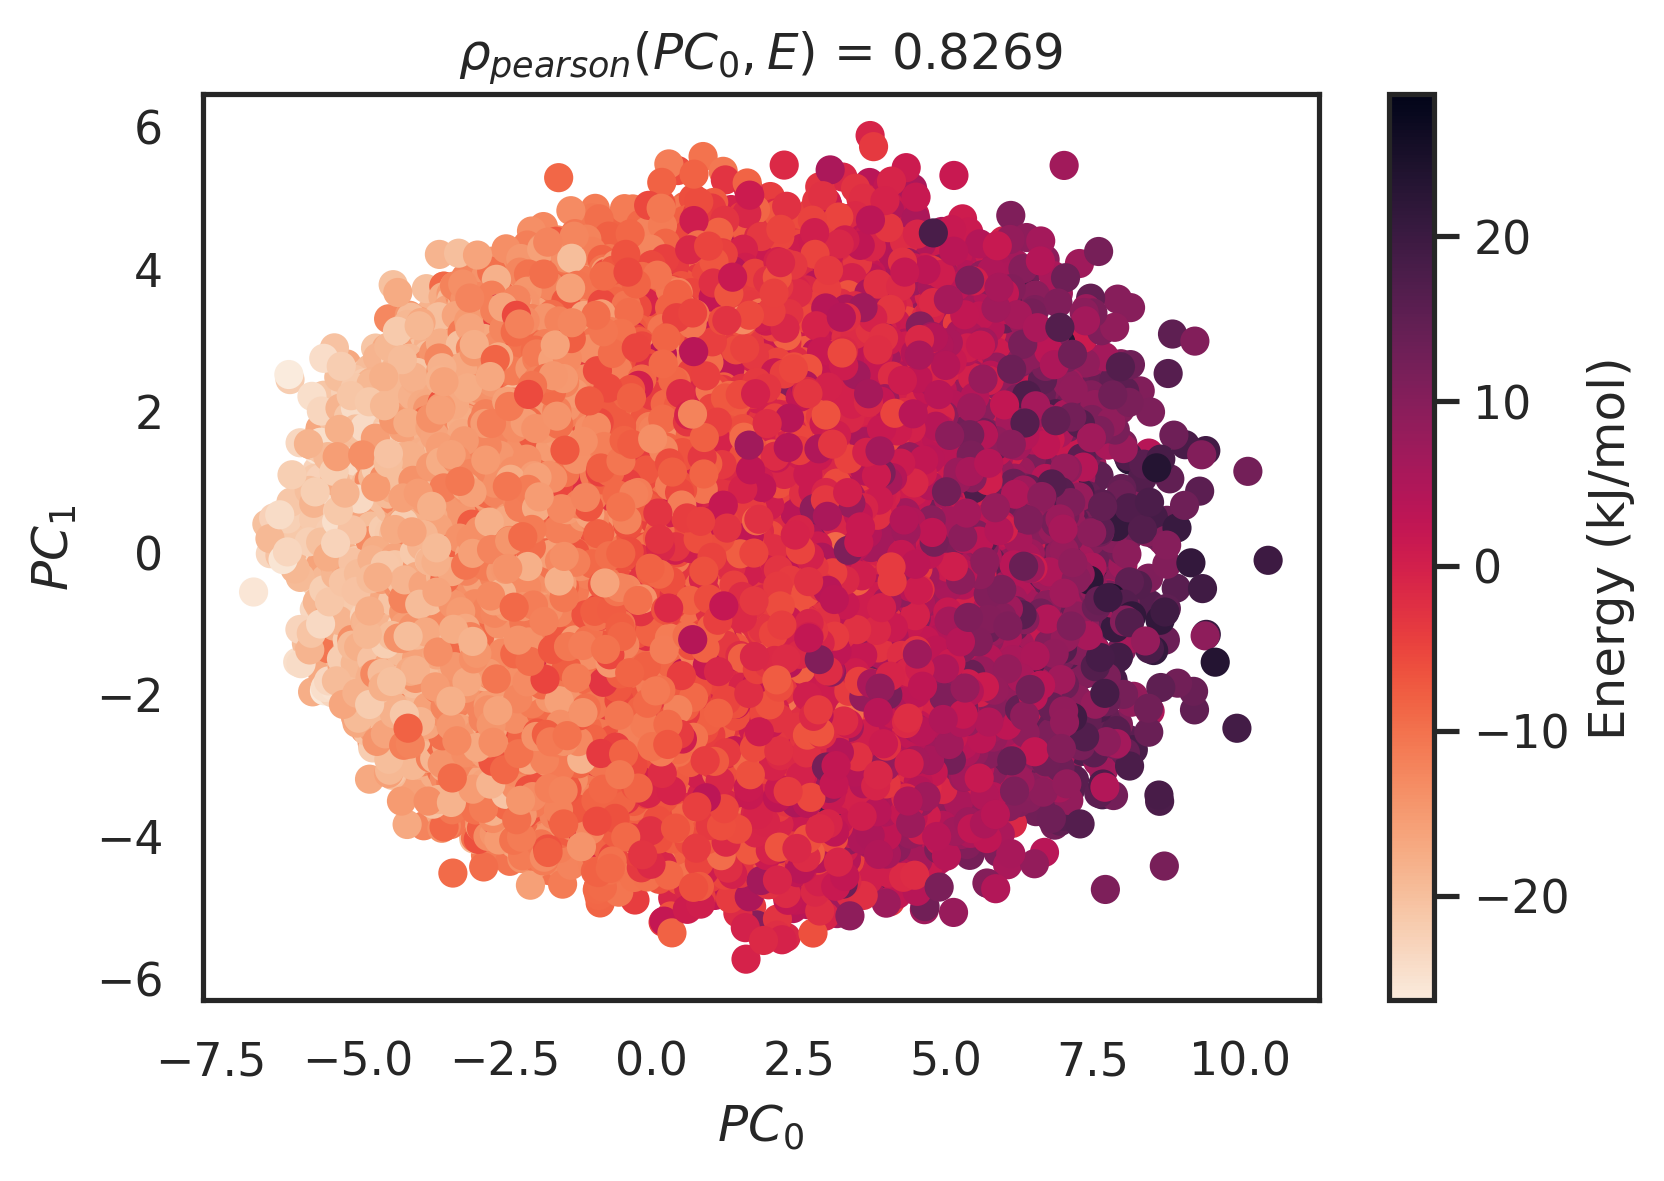

In [8]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)
plt.figure(dpi=300)
cmap = ListedColormap(sns.color_palette("rocket_r", n_colors=256).as_hex())
im = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=Energies.flatten(), cmap=cmap)
plt.colorbar(im, orientation='vertical', label='Energy (kJ/mol)')
plt.title("$\\rho_{pearson}(PC_0, E)$ = " + f'{pearsonr(z_pca[:, 0], Energies.flatten())[0]:.4g}')
plt.xlabel('$PC_0$')
plt.ylabel('$PC_1$')
plt.show() #0.8427

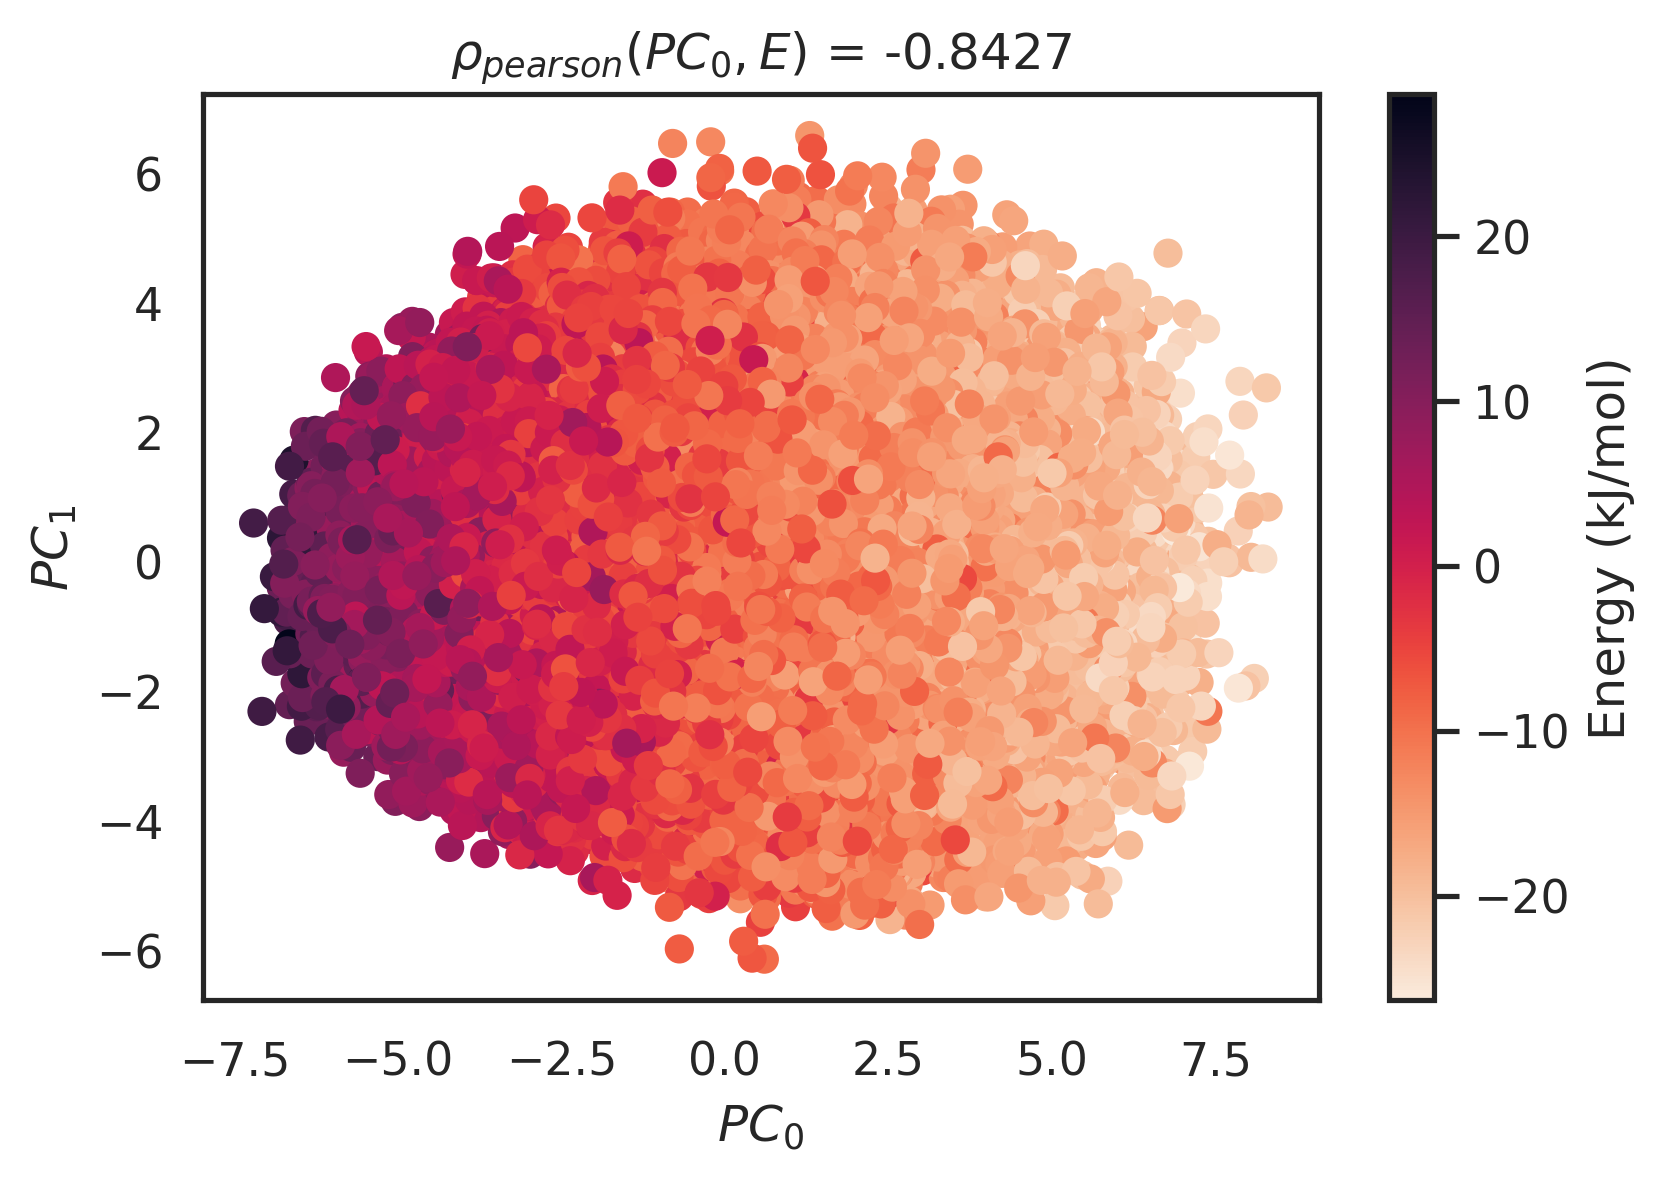

In [8]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)
plt.figure(dpi=300)
cmap = ListedColormap(sns.color_palette("rocket_r", n_colors=256).as_hex())
im = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=Energies.flatten(), cmap=cmap)
plt.colorbar(im, orientation='vertical', label='Energy (kJ/mol)')
plt.title("$\\rho_{pearson}(PC_0, E)$ = " + f'{pearsonr(z_pca[:, 0], Energies.flatten())[0]:.4g}')
plt.xlabel('$PC_0$')
plt.ylabel('$PC_1$')
plt.show() #0.8427

In [9]:
cg_test_trj = md.load('ADP_testset/CG.dcd', top='ADP_testset/CG.pdb').center_coordinates()
cg_test_data = cg_test_trj.xyz

In [10]:
aa_argmin = md.rmsd(model.cg_traj, cg_test_trj, frame=0).argmin()

aa_0 = model.aa_traj[aa_argmin]
R, t = rigid_transform(aa_0.atom_slice(model.cg_idxs).xyz[0], cg_test_trj.xyz[0])
aa_0 = model.aa_traj[aa_argmin - 1]
aa_0.xyz = aa_0.xyz @ R + t

In [11]:
with torch.no_grad():
    aa_vox_current = voxel_gauss(
        torch.Tensor(aa_0[0].xyz).to(model.device),
        res=model.hparams.resolution,
        width=model.hparams.length,
        sigma=model.hparams.sigma,
        device=model.device)

    fake_coords = list()
    for i in tqdm(range(cg_test_trj.n_frames), leave=False):
        cg_vox = voxel_gauss(
            torch.Tensor(cg_test_trj[i].xyz).to(model.device),
            res=model.hparams.resolution,
            width=model.hparams.length,
            sigma=model.hparams.sigma,
            device=model.device)

        condition = torch.cat((cg_vox, aa_vox_current), dim=1)

        z = model.sample_GMM_latent_space()

        recon_aa_vox = model.decode(z, condition)

        aa_fake = avg_blob(
            recon_aa_vox,
            res=model.hparams.resolution,
            width=model.hparams.length,
            sigma=model.hparams.sigma,
            device=model.device,
        )
        aa_fake = aa_fake - aa_fake.mean(dim=1)
        fake_coords.append(aa_fake)

        aa_vox_current = voxel_gauss(
            aa_fake,
            res=model.hparams.resolution,
            width=model.hparams.length,
            sigma=model.hparams.sigma,
            device=model.device)

In [12]:
hallucinate_coords = torch.cat(fake_coords, dim=0)
hallucinate_trj = md.Trajectory(hallucinate_coords.detach().cpu().numpy(), topology=model.aa_traj.top).center_coordinates()
hallucinate_trj.save_dcd('ADP_testset/hallucinated.dcd')